# Практическия реализация NLP

# Colab: https://drive.google.com/file/d/1EB3Nbyk7oXJOP0KYaU2V_dPY2g6bFdre/view?usp=sharing

In this assignment you will perform sentiment analysis of the IMDBs reviews by using RNN.

In [ ]:
!pip install torch==1.6.0
!pip install torchtext==0.7
!pip install numpy
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import torch

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
import statistics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchtext
from torchtext import datasets
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

import warnings
warnings.filterwarnings('ignore')

### Preparing Data

In [ ]:
TEXT = Field(sequential=True, lower=True)
LABEL = LabelField()

In [ ]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split()

In [ ]:
%%time
TEXT.build_vocab(trn)

CPU times: user 2.1 s, sys: 61.1 ms, total: 2.16 s
Wall time: 3.56 s


In [ ]:
LABEL.build_vocab(trn)

In [ ]:
TEXT.vocab.freqs.most_common(10)

[('the', 225872),
 ('a', 112309),
 ('and', 111082),
 ('of', 101481),
 ('to', 93782),
 ('is', 73187),
 ('in', 63617),
 ('i', 49479),
 ('this', 48647),
 ('that', 46260)]

### Creating the Iterator

During training, we'll be using a special kind of Iterator, the **BucketIterator**. 

All the neural networks require to have inputs of the same shape and size. So the data saples should be padded to the same length before gathering them into batches:

e.g.
\[ 
\[3, 15, 2, 7\],
\[4, 1\], 
\[5, 5, 6, 8, 1\] 
\] -> \[ 
\[3, 15, 2, 7, **0**\],
\[4, 1, **0**, **0**, **0**\], 
\[5, 5, 6, 8, 1\] 
\] 

If the sequences of one batch differ greatly in length, the padding will consume a lot of wasteful memory and time. The BucketIterator groups sequences of similar lengths together for each batch to minimize padding.

The **BucketIterator** usage:

In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(64, 64, 64),
        sort=True,
        sort_key=lambda x: len(x.text),
        sort_within_batch=False,
        device='cuda',
        repeat=False
)

Let's take a look at the output of the BucketIterator

In [ ]:
batch = next(train_iter.__iter__()); batch.text

tensor([[  1264,   9368,  24308,  ...,      9,   2786,  31670],
        [   136,  30492,      2,  ...,    368,   1185,      7],
        [  2161,      7,  26960,  ...,  12854,      3,      3],
        ...,
        [     1,      1,      1,  ...,     48,      3,     87],
        [     1,      1,      1,  ...,     32,      6,    138],
        [     1,      1,      1,  ..., 128809,   4432,   5757]],
       device='cuda:0')

The batch contains all the fields we passed to the Dataset object that can be accessed as attributes with the corresponding names.

In [ ]:
batch.__dict__.keys()

dict_keys(['batch_size', 'dataset', 'fields', 'input_fields', 'target_fields', 'text', 'label'])

### Define the RNN-based text classification model

Let's start with the simple architecture. Implement the model according to the scheme below.  
![alt text](https://miro.medium.com/max/1396/1*v-tLYQCsni550A-hznS0mw.jpeg)


# ======= ВНИМАНИЕ =======
В задании указано: "Определите модель классификации текста на основе **RNN**", а на рисунке указана сеть на основе GRU. 

Т.к. непонятно что делать - то реализую 3 варианта:

* **RNN** - простую сеть на RNN, 
* **GRU** - сеть c немного улучшенными параметрами и сделал её двунаправленной для улучшения score
* **BERT** - модель на основе предобученной модели BERT - эксперимент для сравнения качества моделей

# ======= RNN =======

In [ ]:
class RNNBaseline(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_dim = vocab_dim
        self.n_classes = 2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

        # Layers
        self.emb_layer = nn.Embedding(self.vocab_dim, self.emb_dim)
        self.rnn_layer = nn.RNN(self.emb_dim, self.hidden_dim)
        self.linear_layer = nn.Linear(self.hidden_dim, 1)

            
    def forward(self, seq):
        emb = self.emb_layer(seq)  # seq = [seq len, batch size], emb = [seq len, batch size, self.emb_dim]
        output, hidden = self.rnn_layer(emb)  # output = [sent len, batch size, hid dim]  # hidden = [1, batch size, hid dim]
        preds =  self.linear_layer(hidden.squeeze(0))      
        return preds 

In [ ]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model_rnn = RNNBaseline(nh, em_sz, v_size)
model_rnn

RNNBaseline(
  (emb_layer): Embedding(202588, 200)
  (rnn_layer): RNN(200, 300)
  (linear_layer): Linear(in_features=300, out_features=1, bias=True)
)

*If* you're using GPU, remember to call model.cuda() to move your model to the GPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [ ]:
model_rnn.to(device)

RNNBaseline(
  (emb_layer): Embedding(202588, 200)
  (rnn_layer): RNN(200, 300)
  (linear_layer): Linear(in_features=300, out_features=1, bias=True)
)

### Training loop

Define the optimizer and the loss function

In [ ]:
opt = optim.SGD(model_rnn.parameters(), lr = 0.01)
loss_func = nn.BCEWithLogitsLoss()
loss_func = loss_func.to(device)

Set the number of training epochs

In [ ]:
epochs = 50

Finally, run the training loop

## Функция для использования в RNN и GRU

In [ ]:
%%time
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        running_corrects = 0
        model.train() 

        # i = 0
        for batch in train_iter: 
            x = batch.text
            y = batch.label
            if x.shape[1] != 64:
                break
            y_r = y.reshape(64,1).float()

            opt.zero_grad()
            preds = model(x)
            loss = loss_func(preds, y_r)

            loss.backward()
            opt.step()
            running_loss += loss.item()

            # if i % 100 == 0:
            #    print('TRAIN, n bath:', i)

            # i += 1

        epoch_loss = running_loss / len(trn)
      
        val_loss = 0.0
        model.eval()
        for batch in val_iter:
            
            x = batch.text
            y = batch.label
            if x.shape[1] != 64:
                break
            y_r = y.reshape(64,1).float()
            
            preds = model(x, ) 
            loss = loss_func(preds, y_r)
            val_loss += loss.item()
            
        val_loss /= len(vld)
        print(f'Epoch: {epoch}, Training Loss: {epoch_loss}, Validation Loss: {val_loss}')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


## Train RNN

In [ ]:
train_model(model_rnn, epochs)

Epoch: 1, Training Loss: 0.010816132436479841, Validation Loss: 0.010859021425247192
Epoch: 2, Training Loss: 0.010740893459320068, Validation Loss: 0.010842136279741923
Epoch: 3, Training Loss: 0.010688283784048899, Validation Loss: 0.010828282968203227
Epoch: 4, Training Loss: 0.010642324365888323, Validation Loss: 0.010815674646695455
Epoch: 5, Training Loss: 0.010597916878972736, Validation Loss: 0.010802746526400248
Epoch: 6, Training Loss: 0.010552611003603255, Validation Loss: 0.010787582262357076
Epoch: 7, Training Loss: 0.010504889222553798, Validation Loss: 0.010767136017481487
Epoch: 8, Training Loss: 0.010453326511383056, Validation Loss: 0.010737139900525411
Epoch: 9, Training Loss: 0.010395997922761099, Validation Loss: 0.010698704417546591
Epoch: 10, Training Loss: 0.010331494222368513, Validation Loss: 0.010675577410062155
Epoch: 11, Training Loss: 0.010263893682616097, Validation Loss: 0.010635372972488403
Epoch: 12, Training Loss: 0.0101421080827713, Validation Loss: 

### Calculate performance of the trained model (10 points)

In [ ]:
def get_score(model):
    recall_score_list = []
    precision_score_list = []
    f1_score_list = []
    accuracy_score_list = []

    for batch in test_iter:
        x = batch.text
        y = batch.label
        if x.shape[1] != 64:
            break
        y_r = y.reshape(64,1).cpu().detach().numpy()
        p = model(x)
        pred = torch.round(torch.sigmoid(p))
        y_pred = pred.cpu().detach().numpy()
        # y_pred = np.where(pred > 0.5, 1, 0)

        recall_score_list.append(recall_score(y_r, y_pred))
        precision_score_list.append(precision_score(y_r, y_pred)) 
        f1_score_list.append(f1_score(y_r, y_pred))
        accuracy_score_list.append(accuracy_score(y_r, y_pred))


    recall = statistics.mean(recall_score_list)
    precision = statistics.mean(precision_score_list)
    f1 = statistics.mean(f1_score_list)
    accuracy = statistics.mean(accuracy_score_list)

    print('ACCURACY: ', accuracy)
    print('PRECISION: ', precision)
    print('RECALL: ', recall)
    print('F1 SCORE: ', f1)

In [ ]:
get_score(model_rnn)

ACCURACY:  0.576602564102564
PRECISION:  0.5651822469714691
RECALL:  0.5860584185555081
F1 SCORE:  0.5525374224972183


Report the calculated performance below

#### Accuracy: **0.5766**
#### Precision: **0.5652**
#### Recall: **0.5860**
#### F1: **0.5525**

# ======= GRU =======

Изменения по сравнению с RNN моделью:

* слои **GRU**, 
* двунаправленная сеть **bidirectional=True**
* добавляем **dropout**
* оптимизатор - **Adam**

In [ ]:
class GRUmodel(nn.Module):
    def __init__(self, hidden_dim, emb_dim, vocab_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.vocab_dim = vocab_dim
        self.n_classes = 2
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

        # Layers
        self.emb_layer = nn.Embedding(self.vocab_dim, self.emb_dim)
        self.gru_layer = nn.GRU(self.emb_dim, self.hidden_dim, bidirectional=True)
        self.linear_layer = nn.Linear(self.hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.2)

            
    def forward(self, seq):
        batch_size = seq.size(1)
        h = Variable(torch.zeros((2, batch_size, self.hidden_dim)).to(self.device))  # initialize hidden state of GRU

        emb = self.emb_layer(seq)  # seq = [seq len, batch size], emb = [seq len, batch size, self.emb_dim]
        out, hidden = self.gru_layer(emb, h)  # out = [sent len, batch size, hid dim]  # hidden = [1, batch size, hid dim]
        h = self.dropout(torch.cat([hidden[-1], hidden[-2]], dim=-1))
        preds = self.linear_layer(h.squeeze(0))
        return preds

In [ ]:
em_sz = 200
nh = 300
v_size = len(TEXT.vocab)
model_gru = GRUmodel(nh, em_sz, v_size)
model_gru

GRUmodel(
  (emb_layer): Embedding(202588, 200)
  (gru_layer): GRU(200, 300, bidirectional=True)
  (linear_layer): Linear(in_features=600, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
model_gru.to(device)

GRUmodel(
  (emb_layer): Embedding(202588, 200)
  (gru_layer): GRU(200, 300, bidirectional=True)
  (linear_layer): Linear(in_features=600, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
opt = optim.Adam(model_gru.parameters(), lr = 0.00001)
loss_func = nn.BCEWithLogitsLoss() 
loss_func = loss_func.to(device)

In [ ]:
epochs = 30

In [ ]:
train_model(model_gru, epochs)

Epoch: 1, Training Loss: 0.010810070453371321, Validation Loss: 0.010762339289983113
Epoch: 2, Training Loss: 0.010735974846567426, Validation Loss: 0.010717456364631653
Epoch: 3, Training Loss: 0.010663935913358416, Validation Loss: 0.01067849539120992
Epoch: 4, Training Loss: 0.010610184492383684, Validation Loss: 0.010640575528144836
Epoch: 5, Training Loss: 0.010543423141751971, Validation Loss: 0.010600974114735921
Epoch: 6, Training Loss: 0.010474971985816955, Validation Loss: 0.010556884431838989
Epoch: 7, Training Loss: 0.010404274606704712, Validation Loss: 0.010505102968215942
Epoch: 8, Training Loss: 0.010315443641798837, Validation Loss: 0.010439911754926045
Epoch: 9, Training Loss: 0.01021525731086731, Validation Loss: 0.01034961876074473
Epoch: 10, Training Loss: 0.01005794382095337, Validation Loss: 0.01020822984377543
Epoch: 11, Training Loss: 0.009805708268710545, Validation Loss: 0.009949998807907104
Epoch: 12, Training Loss: 0.009212560047422137, Validation Loss: 0.0

In [ ]:
get_score(model_gru)

ACCURACY:  0.7565705128205128
PRECISION:  0.7061131160201255
RECALL:  0.7586275849862272
F1 SCORE:  0.7189842718030904


Сообщите о рассчитанной эффективности ниже

#### Accuracy: **0.7566**
#### Precision: **0.7061**
#### Recall: **0.7586**
#### F1: **0.7190**

In [ ]:
torch.cuda.empty_cache()

### Experiments

Feel free to experiment with the model to improve performance scores. You can find advices [here](https://arxiv.org/abs/1801.06146). 

Below describe, please, 
 - your improvements and challenges you faced
 - provide your experiments' implementation details
 - explain your choice of architecture/training method/regularization techniques etc.

### 1. .. 
Проблема - PyTorch - не уютный для меня фреймворк, по сравнению с tf.keras

Проблема 2 - колаб выбрасывает через 4 часа (GPU) с блокировкой на сутки. 

### 2. ..
Реализовано 3 эксперимента - простая сеть RNN, bidirectional GRU, сеть на основе BERT. Для улучшения 2-й модели по сравнению с первой были предприняты решения: 

* слои **GRU**, 
* двунаправленная сеть **bidirectional=True**
* добавляем **dropout**
* оптимизатор - **Adam**

По моему опыту лучшие решения по классификации текста - на предобученной модели BERT с размороженным последнем слоем. Создал модель на BERT для сравнения результатов

### 3. ..

**Оптимизатор Adam** (и его разновидности) - с моей точки зрения - лучший. В нашем случае бинарная кроссэнтропия - лучший выбор (модель обучается быстрее - много раз тестировал ранее). 

**Dropout** - обычно даёт неплохие результаты в пределах 0.2 - 0.3

**Нормализация** - это хорошо, но не в нашем случае (нормализовать индексы слов - плохая идея) - не используем

**bidirectional=True** - по сути двунаправленное прохождение текста - результат лучше

**Softmax** - логарифмическая зависимость увеличивает стремление выходных значений к 0 или 1, а это важно для бинарной кроссэнтропии, т.к. если мы подадим y_true = 0.9 и y_pred = 0.9 на вход бинарной кроссэнтропии, то не смотря на то, что значения равны, loss бинарной кроссэнтропии не будет равен 0

#=====================================================
С моделью на основе BERT тяжело состязаться, но можно предпринять ряд мер для первых 2 моделей:

- лемматизация текста
- увеличение размера embadding (подбирается экспериментально)
- регуляризация (надо тестировать различные варианты)
- использование в качестве входных весов (embadding) веса слов, например из fasttext - даёт очень хороший прирост к точности
- подбор количества и типов различных архитектур нейросетей для ансамблевой модели
- использовать ансамблевую нейросеть GRU bidirectional + многослойную CNN (Conv1d) с пробросами связей от верхнего уровня до следующих слоёв
- извлечь дополнительные признаки из текста, такие как: 
-- длина сообщения, 
-- доля уникальных слов (например, ругательства состоят из повторяющихся слов)
-- доля ошибок
-- доля слов набранных CAPS LOCK
-- и др.
- данные признаки подать на дополнительный вход ансамблевой нейросети, это может дать до 0.2% к увеличению точности
- попробовать различные варианты оптимизатора Adam
- сделать callback функцию, которая запишет веса на лучших показаниях валидационной выборки.
- использовать генетический алгоритм для подбора как гиперпараметров сети, так и количества слоёв (требуется огромное количество времени)

# ======= BERT =======
Лучшую точность классификации данных даст модель на BERT

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

In [ ]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

import tensorflow_hub as hub
import tensorflow_text as text

## Load data IMDB

In [ ]:
train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], 
                                  batch_size=-1, as_supervised=True)

train_x, train_y = tfds.as_numpy(train_data)
test_x, test_y = tfds.as_numpy(test_data)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [ ]:
train_y_cat = to_categorical(train_y, dtype='int')
test_y_cat = to_categorical(test_y, dtype='int')

In [ ]:
train_x[:2]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [ ]:
train_y_cat[0:10]

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

## Load text preprocessor, load pretrained model

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

## Model

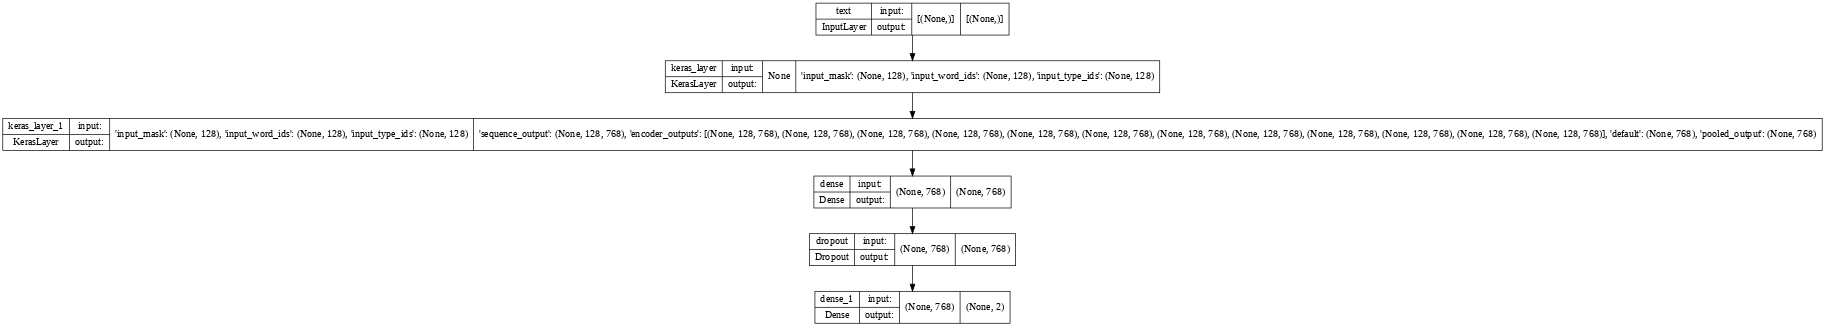

In [ ]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = outputs['pooled_output']
x = Dense(768, activation='relu')(x)
x = Dropout(0.25)(x)
x_output = Dense(2, activation='softmax')(x)

model_bert = Model(inputs=[text_input], outputs = [x_output])
plot_model(model_bert, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [ ]:
model_bert.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=(0.00001)), metrics=['accuracy', 'Precision', 'Recall', tfa.metrics.F1Score(2)])

In [ ]:
history = model_bert.fit(
    x = train_x,
    y = train_y_cat, 
    epochs = 5,
    batch_size = 8,
    validation_split = 0.1,
    verbose = 1
)

Epoch 1/5
2813/2813 [==============================] - 767s 266ms/step - loss: 0.3383 - accuracy: 0.8519 - precision: 0.8519 - recall: 0.8519 - f1_score: 0.8519 - val_loss: 0.2835 - val_accuracy: 0.8772 - val_precision: 0.8772 - val_recall: 0.8772 - val_f1_score: 0.8771
Epoch 2/5
2813/2813 [==============================] - 745s 265ms/step - loss: 0.2012 - accuracy: 0.9200 - precision: 0.9200 - recall: 0.9200 - f1_score: 0.9200 - val_loss: 0.2927 - val_accuracy: 0.8832 - val_precision: 0.8832 - val_recall: 0.8832 - val_f1_score: 0.8832
Epoch 3/5
2813/2813 [==============================] - 744s 264ms/step - loss: 0.1067 - accuracy: 0.9632 - precision: 0.9632 - recall: 0.9632 - f1_score: 0.9632 - val_loss: 0.3744 - val_accuracy: 0.8788 - val_precision: 0.8788 - val_recall: 0.8788 - val_f1_score: 0.8788
Epoch 4/5
2813/2813 [==============================] - 743s 264ms/step - loss: 0.0559 - accuracy: 0.9820 - precision: 0.9820 - recall: 0.9820 - f1_score: 0.9820 - val_loss: 0.4094 - val_a

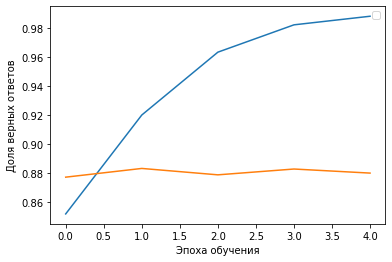

In [ ]:
# Оображаем график точности обучения
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оценка модели

In [ ]:
predict = model_bert.predict(test_x)

In [ ]:
predict_r = np.round_(predict)
predict_r

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
test_y_c = test_y_cat.astype(np.float32)
test_y_c

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
recall = recall_score(test_y_c, predict_r, average='weighted')
precision = precision_score(test_y_c, predict_r, average='weighted') 
f1 = f1_score(test_y_c, predict_r, average='weighted')
acc = accuracy_score(test_y_c, predict_r)

In [ ]:
print(f'ACCURACY: {round(acc, 4)}')
print(f'PRECISION: {round(precision, 4)}')
print(f'RECALL: {round(recall, 4)}')
print(f'F1 SCORE: {round(f1, 4)}')

ACCURACY: 0.8802
PRECISION: 0.8827
RECALL: 0.8802
F1 SCORE: 0.88


Сообщите о рассчитанной эффективности ниже

#### Accuracy: **0.8802**
#### Precision: **0.8827**
#### Recall: **0.8802**
#### F1: **0.88**

# Вывод
Модель на основе BERT показала лучший результат.